### To determine the contents of a file:

In [1]:
import opusFC
import pandas as pd
import matplotlib.pyplot as plt

f = r"R:\Jeff\FTIR\Structural Mapping\6.16.2022 UV Circles\left circle 8x8.0"
dbs = opusFC.listContents(f)
print(dbs)
dbs[1]

[('AB', '3D', 'NONE'), ('SSC', '3D', 'NONE'), ('RSC', '2D', 'NONE'), ('TRC', '3D', 'NONE')]


('SSC', '3D', 'NONE')

### Load the first datablock in dbs: 

In [2]:
data = opusFC.getOpusData(f, dbs[1])
data


This object contains:
	dimension of file (.dimension)
	data block type (.dataType)
	derivative type (.derivative)
	dictionary of parameters with parameter name then value (.parameters)
	spectrum x coordinates (.x)
	minimum and maximum y values (.minY and .maxY)
	list of regions (.regions)

	each region is a Region object containing:
		description of region (title)
		x mapping coordinates array (mapX)
		y mapping coordinates array (mapY)
		timestamps of spectrum acquisition array (start_time)
		2D array containing spectra in the region (spectra)
		access a spectrum with
			returnedObject.regions[region index].spectra[row]

In [3]:
data.regions[0].spectra[:]

array([[0.45977598, 0.45709765, 0.45452517, ..., 0.03659058, 0.03458279,
        0.03256302],
       [0.4601276 , 0.45743984, 0.45487684, ..., 0.03616006, 0.03408296,
        0.03202186],
       [0.44583243, 0.44317454, 0.44063598, ..., 0.03710095, 0.03506348,
        0.03301638],
       ...,
       [0.41711947, 0.41455656, 0.41210702, ..., 0.03913495, 0.03704912,
        0.03497604],
       [0.41398948, 0.41140765, 0.4089783 , ..., 0.03786776, 0.03576127,
        0.03368725],
       [0.41648325, 0.4139319 , 0.41150194, ..., 0.03845468, 0.03636736,
        0.03430095]], dtype=float32)

#####This is the money part: extracting x and y data

In [19]:
#make a dictionary of x-y location data
xydict = {'x_coordinate':data.regions[0].mapX[:],'y coordinate':data.regions[0].mapY[:]}#,data.x:data.regions[0].spectra[:]}

21243.0
27344.5


In [5]:
#Make a loop or use a fancy 1 liner to take all of the X and Y data from here and then put it in a dataframe as the first 2 rows, or maybe the 2nd and 3rd rows 
# (probably best to have name/title of column, then x, then y, then data)
xydataframe = pd.DataFrame(data=xydict)#[data.regions[0].mapX[:],data.regions[0].mapY[:]])
xydataframe.head(3)

,x_coordinate,y coordinate
0,23794.0,21243.0
1,24977.5,21243.0
2,26161.0,21243.0


In [6]:
data.regions[0].spectra[0]

array([0.45977598, 0.45709765, 0.45452517, ..., 0.03659058, 0.03458279,
       0.03256302], dtype=float32)

In [54]:
#make dataframe of actual apectra

spectra_df = pd.DataFrame(data.regions[0].spectra[:])
#spectra_df
spectra_df =spectra_df.transpose()
labeledspectra_df = spectra_df.set_index(data.x)#what does drop do here? seemingly nothing
#spectra_df['wavenumber'] = data.x

tlabeledspectra_df = labeledspectra_df.transpose()

tlabeledspectra_df.head(3)

,3998.516413,3997.088371,3995.660329,3994.232288,3992.804246,3991.376205,3989.948163,3988.520122,3987.092080,3985.664038,...,612.629836,611.201794,609.773753,608.345711,606.917670,605.489628,604.061587,602.633545,601.205503,599.777462
0,0.459776,0.457098,0.454525,0.453151,0.452703,0.453089,0.455120,0.458629,0.461486,0.461868,...,0.046596,0.045656,0.044418,0.043078,0.041655,0.040120,0.038445,0.036591,0.034583,0.032563
1,0.460128,0.457440,0.454877,0.453524,0.453092,0.453489,0.455538,0.459067,0.461931,0.462294,...,0.046092,0.045190,0.044033,0.042747,0.041327,0.039771,0.038067,0.036160,0.034083,0.032022
2,0.445832,0.443175,0.440636,0.439286,0.438834,0.439181,0.441139,0.444560,0.447362,0.447760,...,0.046972,0.046079,0.044927,0.043619,0.042175,0.040625,0.038960,0.037101,0.035063,0.033016


In [140]:
complete_df.iloc[1][2:]

3998.516413    0.460128
3997.088371    0.457440
3995.660329    0.454877
3994.232288    0.453524
3992.804246    0.453092
                 ...   
605.489628     0.039771
604.061587     0.038067
602.633545     0.036160
601.205503     0.034083
599.777462     0.032022
Name: 1, Length: 2381, dtype: float64

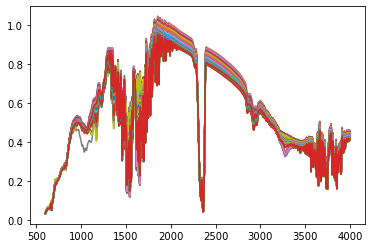

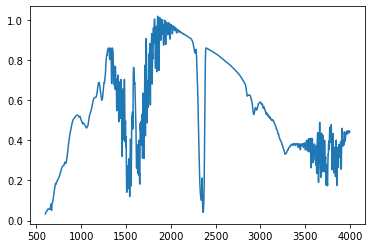

In [146]:
#complete_df = xydataframe
# for i in range(len(data.x)):
#     complete_df = pd.concat(xydataframe, labeledspectra_df[1])

twodfs = [xydataframe, tlabeledspectra_df]

complete_df = pd.concat(twodfs, axis=1,join='inner')

(complete_df.T).to_csv(r'C:\Users\jrosh\Documents\FTIR_Mapping\Results\test.csv')

x = [key for key in complete_df.keys() if type(key) == float]
complete_df[x]

fig, ax = plt.subplots()    # create figure and axes
for index, row in complete_df[x].iterrows(): 
    ax.plot(x, row)
plt.show()
#complete_df.keys(2::)



plt.plot(x,complete_df.iloc[2][2:])

In [60]:
complete_df.columns[2:]



Index([ 3998.516412597656, 3997.0883710217286,  3995.660329445801,
        3994.232287869873,  3992.804246293945, 3991.3762047180176,
         3989.94816314209,  3988.520121566162,  3987.092079990234,
       3985.6640384143066,
       ...
        612.6298360729975,  611.2017944970698,  609.7737529211422,
        608.3457113452146,  606.9176697692869,  605.4896281933588,
        604.0615866174312,  602.6335450415036,  601.2055034655759,
        599.7774618896484],
      dtype='object', length=2381)

In [73]:
complete_df.iterrows()
complete_df.iloc[3,:][2:]

3998.516413    0.441578
3997.088371    0.438985
3995.660329    0.436477
3994.232288    0.435131
3992.804246    0.434690
                 ...   
605.489628     0.039587
604.061587     0.037973
602.633545     0.036131
601.205503     0.034086
599.777462     0.032038
Name: 3, Length: 2381, dtype: float64

In [84]:
complete_df[3]

KeyError: 3

In [88]:
loc = list(map(float, complete_df.columns[2:]))


print(len(complete_df.columns[2:]))
print(len(loc))
print(complete_df.loc[1,[2:]])

fig, ax = plt.subplots()
for row in complete_df.iterrows():
    ax.scatter(row[1], loc, label=row[1].name)

plt.legend()    
plt.show()

SyntaxError: invalid syntax (Temp/ipykernel_18396/3602723537.py, line 5)

ValueError: x and y must be the same size

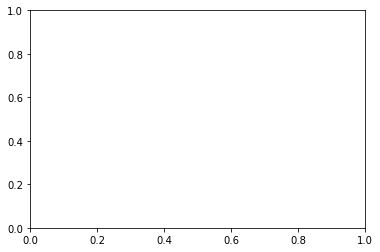

In [70]:
fig, ax = plt.subplots()
# for row in complete_df.iterrows():
#     ax.scatter(row[1], complete_df.columns[2:] , label=row[1].name)

ax.scatter(complete_df.iloc[1,:], complete_df.columns[2:] , label=row[1].name)
complete_df.iloc[1,:]

plt.legend()    
plt.show()

### Access loaded data and parameters:

In [ ]:
data.x                    # X coordinates
data.parameters['SNM']    # Sample name
data.description          # Description of data object
opusFC.paramDict['SNM']     # String description of SNM

### Access and save visible images:

In [ ]:
images = opusFC.getVisImages(f)

for img in images:
    data = img['image']
    title = img['Title']
    imgext = img['imgext']
    f = "{0}_{1}.{2}".format(f, title, imgext)
    with open(f, 'wb') as fd:
        fd.write(data)

In [ ]:
d_db = pd.DataFrame()
bt = tuple()
for things in dbs:
    print(opusFC.getOpusData(f,things))

In [ ]:
d

In [ ]:
opusFC.MultiRegionTRCDataReturn(labels, regions, **kwds)